# **Vision Transformer for Brain Tumor Image Classification**
In this notebook, we explore the powerful capabilities of Vision Transformers (ViT) in solving the complex task of Image Classification on the Brain Tumor dataset. Traditional Convolutional Neural Networks (CNNs) have been the go-to architecture for image-related tasks, but ViT brings a fresh perspective by introducing self-attention mechanisms inspired by the Transformer architecture originally designed for natural language processing.

The Brain Tumor dataset used in this notebook contains a collection of brain MRI scans, with each scan categorized into 4 classes. Our objective is to train a custom ViT model to accurately classify these MRI scans based on their content.

# What is a Vision Transformer (ViT)?
A Vision Transformer is a deep learning architecture that applies the Transformer model, initially designed for sequential data like text, to image data. This innovative approach divides an input image into fixed-size patches, which are then linearly embedded into vectors. These embedded vectors are treated as sequences and processed by Transformer layers, enabling ViT to capture both local and global dependencies within the image.

# About the Brain Tumor Dataset
The Brain Tumor dataset is a crucial collection of brain MRI scans acquired from patients with and without brain tumors. Each image in the dataset presents a unique challenge due to varying sizes, resolutions, and contrasts. Our goal is to leverage the ViT architecture to develop a robust classification model that can accurately identify the presence of brain tumors in these MRI scans.

# Custom ViT Model Architecture
In this notebook, we've designed a custom ViT model tailored for the Brain Tumor classification task. The model consists of an initial patch embedding layer, followed by multiple Transformer encoder layers. The self-attention mechanism of the Transformer allows the model to learn intricate spatial relationships between different regions of the brain images, contributing to its classification accuracy.

# Note
If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention

from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast

from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import plot_model
from functools import partial
import seaborn as sns
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
learning_rate = 0.0001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 120
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
num_layers = 15
Hidden_size=64
mlp_head_units = 1024

# Data Prepartion

In [3]:
train_data='/kaggle/input/brain-tumor-mri-dataset/Training'
test_data='/kaggle/input/brain-tumor-mri-dataset/Testing'

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


# **Data Visualization**


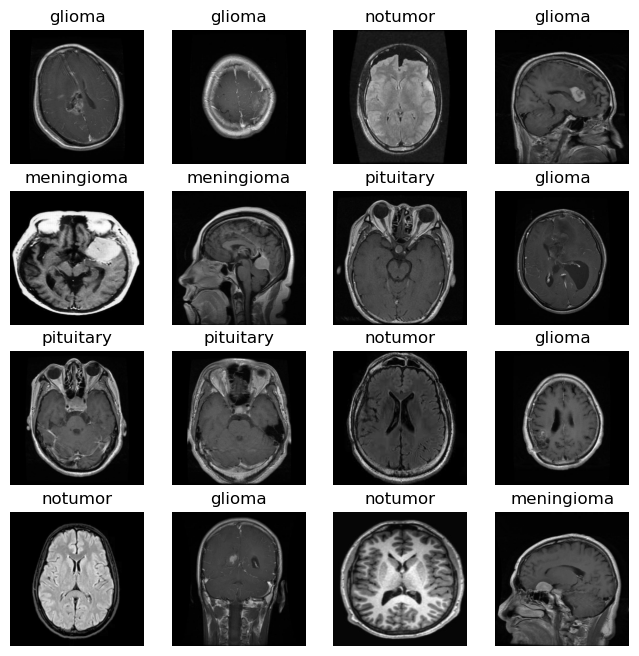

In [5]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))): 
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')  
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


# Data Augmentation

In [6]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])

In [7]:
# Define a custom preprocessing function
def process_data(image, label):
    augmented_image=augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
vali_dataset=(
   val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)


)

In [9]:
input_tensor = next(iter(training_dataset))[0]

In [10]:
patche=tf.image.extract_patches(images=input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')
                                

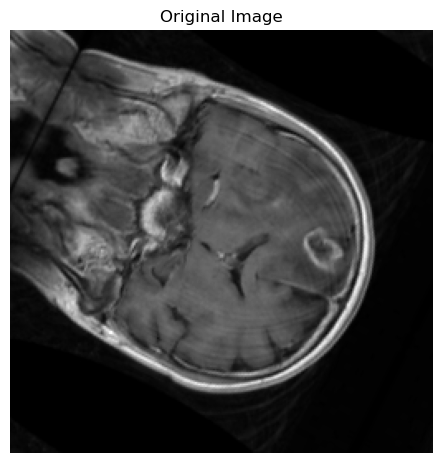

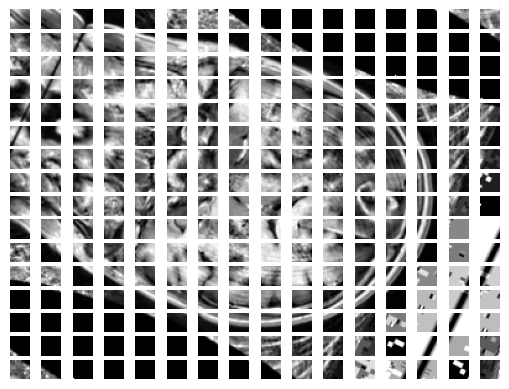

In [11]:


plt.figure(figsize=(12, 12))

batch_size, patch_rows, patch_cols, channels = patche.shape
plt.subplot(1, 2, 1)
plt.imshow(input_tensor[0],cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        plt.imshow(patche[0, i, j, :].numpy().reshape (patch_size,patch_size, 1),cmap='gray')
        plt.axis("off")

plt.show()


# VIT MODEL

In [12]:
class ConvolutionalStem(layers.Layer):
    def __init__(self, hidden_size, image_size=224):
        super(ConvolutionalStem, self).__init__(name='conv_stem')
        
        # Calculate resulting feature map size and number of patches
        self.feature_size = image_size // 16  # After 4 stages with stride 2
        self.num_patches = self.feature_size ** 2
        self.hidden_size = hidden_size
        
        # Convolutional stem layers
        self.conv_layers = tf.keras.Sequential([
            # First stage: 7x7 conv, stride 2
            layers.Conv2D(hidden_size//8, kernel_size=7, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('gelu'),
            
            # Second stage: 3x3 conv, stride 2
            layers.Conv2D(hidden_size//4, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('gelu'),
            
            # Third stage: 3x3 conv, stride 2
            layers.Conv2D(hidden_size//2, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('gelu'),
            
            # Final projection: 3x3 conv, stride 2
            layers.Conv2D(hidden_size, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('gelu'),
        ])
        
        # Position embeddings (same as in original)
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=hidden_size
        )
        
    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        
        # Apply convolutional layers
        features = self.conv_layers(image)
        
        # Reshape to token sequence: (batch_size, h*w, channels)
        features = tf.reshape(features, [batch_size, -1, self.hidden_size])
        
        # Add positional embeddings
        embedding_input = tf.range(start=0, limit=self.num_patches, delta=1)
        output = features + self.position_embedding(embedding_input)
        
        return output

In [13]:
class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads,Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1=LayerNormalization()
        self.layer_norm_2=LayerNormalization()
        
        self.multi_head_att=MultiHeadAttention(Num_heads,Hidden_size)
        
        self.dense_1=Dense(Hidden_size,activation=tf.nn.gelu)
        self.dense_2=Dense(Hidden_size,activation=tf.nn.gelu)


    def call(self, input):
        x=self.layer_norm_1(input)
        x1=self.multi_head_att(x,x)
        
        x1=Add()([x1,input])
        x2=self.layer_norm_2(x1)
        x2=self.dense_1(x2)
        output=self.dense_1(x2)
        output=Add()([output,x1])
      
        return output

In [14]:
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = ConvolutionalStem(hidden_size=Hidden_size, image_size=image_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)

In [15]:
num_patches = (image_size // patch_size) ** 2  # (256//16)^2 = 256 for 256x256 images
Hidden_size = 64  # Dimension of each patch embedding
Num_heads = 4     # Number of attention heads
num_layers = 6    # Number of transformer layers
mlp_head_units = 1024  # Size of classification head

# Initialize model
vit = VIT(
    Num_heads=Num_heads,
    Hidden_size=Hidden_size,
    num_patches=num_patches,
    num_layers=num_layers,
    mlp_head_units=mlp_head_units
)

# Model Training

In [16]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [17]:
metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [18]:
vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
checkpoint_filepath = "/kaggle/working/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [20]:
# Train the model
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]
    
)

Epoch 1/120
143/143 [==============================] - 44s 118ms/step - loss: 1.0884 - accuracy: 0.6344 - val_loss: 1.0825 - val_accuracy: 0.5779
Epoch 2/120
143/143 [==============================] - 18s 103ms/step - loss: 0.6654 - accuracy: 0.7481 - val_loss: 0.6810 - val_accuracy: 0.7093
Epoch 3/120
143/143 [==============================] - 18s 105ms/step - loss: 0.5867 - accuracy: 0.7799 - val_loss: 0.5307 - val_accuracy: 0.7960
Epoch 4/120
143/143 [==============================] - 17s 97ms/step - loss: 0.5358 - accuracy: 0.7917 - val_loss: 0.5258 - val_accuracy: 0.7688
Epoch 5/120
143/143 [==============================] - 19s 110ms/step - loss: 0.4865 - accuracy: 0.8147 - val_loss: 0.4980 - val_accuracy: 0.8170
Epoch 6/120
143/143 [==============================] - 18s 100ms/step - loss: 0.4629 - accuracy: 0.8254 - val_loss: 0.5075 - val_accuracy: 0.7951
Epoch 7/120
143/143 [==============================] - 19s 108ms/step - loss: 0.4217 - accuracy: 0.8317 - val_loss: 0.4170 - 

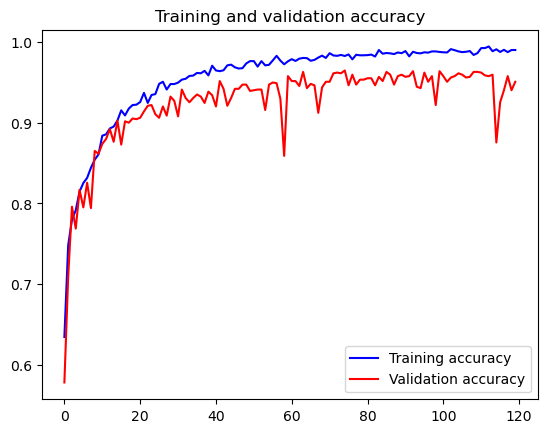

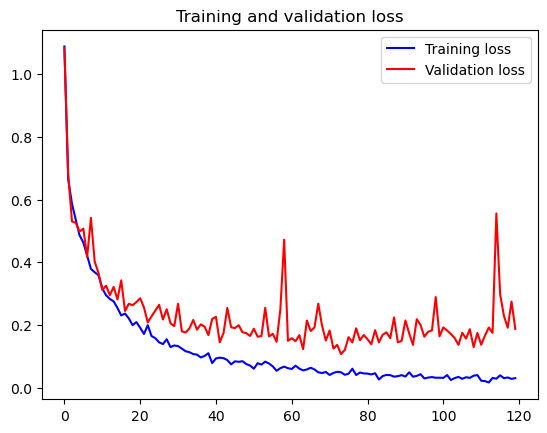

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# vit.save('/kaggle/working/vit_model', save_format='tf')vit.save('/kaggle/working/vit_model', save_format='tf')Saving Model

In [22]:
vit.save('/kaggle/working/vit_model', save_format='tf')

In [23]:
vit.save_weights('/kaggle/working/')

# Prediction

In [24]:
pred = vit.predict(test_dataset)

41/41 [==============================] - 3s 42ms/step


In [25]:
vit.evaluate(test_dataset)

41/41 [==============================] - 2s 36ms/step - loss: 0.2030 - accuracy: 0.9588


[0.20301058888435364, 0.9588100910186768]

In [26]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())

In [27]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

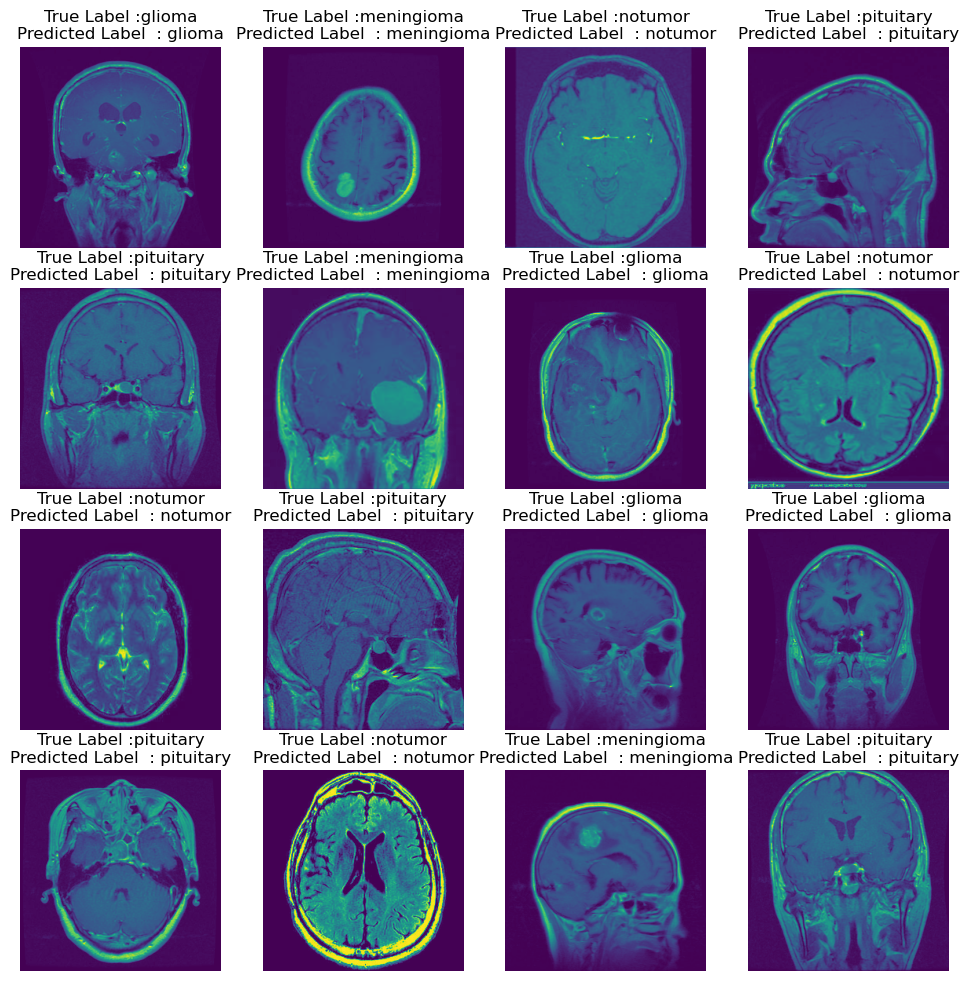

In [28]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

# Confusion Metrics

[[291   7   2   0]
 [ 22 270  12   2]
 [  1   0 404   0]
 [  6   2   0 292]]


Text(0.5, 58.7222222222222, 'Predicted')

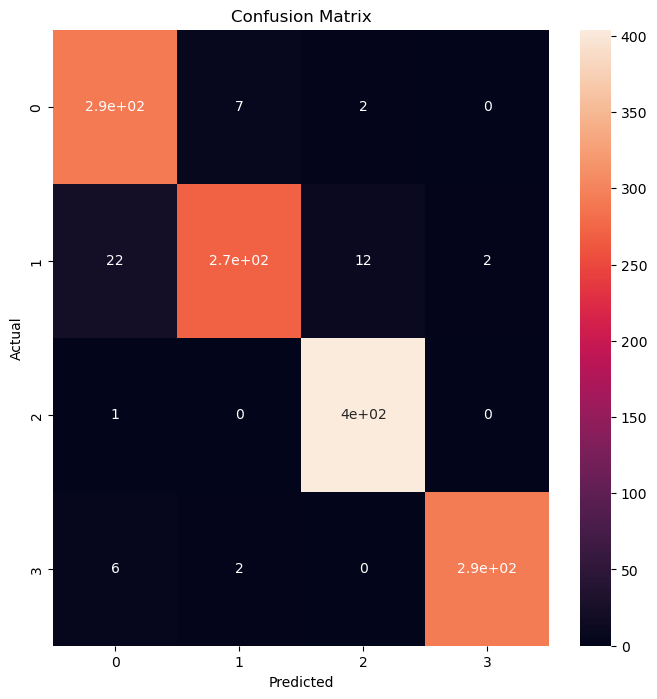

In [29]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")